In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## Step1: Importing Packages

In [2]:
#imporitng the required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import datetime
import calendar
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Step2: Reading and Exploring Data

### 2.1 Reading the Data from CSV and Exploring metadata

In [3]:
dateparse = lambda x: datetime.datetime.strptime(x, '%d-%m-%Y')

df = pd.read_csv("/content/drive/MyDrive/Lecture Notes/Machine Learning 1/Assignment/Bike_Sharing-Linear_Regression/data/day.csv",
                 parse_dates=['dteday'],
                 date_parser=dateparse)
orignal_copy = df
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2018-01-01,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,2018-01-02,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,2018-01-03,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,2018-01-04,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,2018-01-05,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [4]:
#check the shape
df.shape

(730, 16)

In [5]:
#check dataframe for null and datatype 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     730 non-null    int64         
 1   dteday      730 non-null    datetime64[ns]
 2   season      730 non-null    int64         
 3   yr          730 non-null    int64         
 4   mnth        730 non-null    int64         
 5   holiday     730 non-null    int64         
 6   weekday     730 non-null    int64         
 7   workingday  730 non-null    int64         
 8   weathersit  730 non-null    int64         
 9   temp        730 non-null    float64       
 10  atemp       730 non-null    float64       
 11  hum         730 non-null    float64       
 12  windspeed   730 non-null    float64       
 13  casual      730 non-null    int64         
 14  registered  730 non-null    int64         
 15  cnt         730 non-null    int64         
dtypes: datetime64[ns](1), floa

In [6]:
# Description of the data
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


### 2.2 Deriving New Data Columns using the columns which are available

In [7]:
# # Converting the date column to get quater
# df['quarter'] = df['dteday'].dt.to_period('Q')

# Creating a new column to check if its first day or last day of Month
df['start_of_month'] = df['dteday'].dt.is_month_start.astype(int)
df['end_of_month'] = df['dteday'].dt.is_month_end.astype(int)

# Deriving New column using date i.e "week_of_month"
def week_of_month(tgtdate):
    tgtdate = tgtdate.to_pydatetime()

    days_this_month = calendar.mdays[tgtdate.month]
    for i in range(1, days_this_month):
        d = datetime.datetime(tgtdate.year, tgtdate.month, i)
        if d.day - d.weekday() > 0:
            startdate = d
            break
    return (tgtdate - startdate).days //7 + 1

df['week_of_month'] = df['dteday'].apply(week_of_month)

# # Deriving Quarters for in coded for both year
# def q_num(m):
#   return int(str(m)[-1])

# df['quarter'] = df['quarter'].apply(q_num)

In [8]:
# Deriving few percentage change from continueous variable
# df['hum_pct_change'] = df['hum'].pct_change()
# df['temp_pct_change'] = df['temp'].pct_change()
# df['windspeed_pct_change'] = df['windspeed'].pct_change()

In [9]:
# df['hum_diff'] = df['hum'].diff(periods=2)
# df['temp_diff'] = df['temp'].diff(periods=2)
# df['windspeed_diff'] = df['windspeed'].diff(periods=2)

In [10]:
df['temp'].describe()

count    730.000000
mean      20.319259
std        7.506729
min        2.424346
25%       13.811885
50%       20.465826
75%       26.880615
max       35.328347
Name: temp, dtype: float64

In [11]:
# Bucket = [0, 13.0, 20.4, 26.88, 35.32, 99999999999]
# Bucket = [0, 8.75, 17.5, 26.25, 99999999999]
Bucket = [0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 99999999999]
df['temp_cat'] = df['temp'].value_counts(bins=Bucket)
df['temp_cat'].unique()

array([  4,  56, 160, 138, 130, 170,  72])

# Step3: Cleaning Data

### 3.1 Cleaning the data type

In [12]:
# Removing Trailing Spaces in entire dataframe
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

### 3.2 Drop columns that are irrelavent

In [13]:
# Droping instant column since it has nothing to do with target
df.drop(['instant'], axis = 1, inplace = True)

# Dropping casual and registered Columns Since it's sum is directly the target. This could be a major issue for data leak
df.drop(['casual'], axis = 1, inplace = True)
df.drop(['registered'], axis = 1, inplace = True)

# Droping the dteday since date is not relavent here
df.drop(['dteday'], axis = 1, inplace = True)

# Droping the atemp since it is highly correlated to temp
df.drop(['atemp'], axis = 1, inplace = True)

### 3.2 Check for Missing values

- No missing Values were found as we have seen above. Verifying the claim for other columns:

In [14]:
df.isnull().sum()

season            0
yr                0
mnth              0
holiday           0
weekday           0
workingday        0
weathersit        0
temp              0
hum               0
windspeed         0
cnt               0
start_of_month    0
end_of_month      0
week_of_month     0
temp_cat          0
dtype: int64

### 3.3 Checking for Outliers in the dataset

In [15]:

#Unique values in all columns
df.nunique()

season              4
yr                  2
mnth               12
holiday             2
weekday             7
workingday          2
weathersit          3
temp              498
hum               594
windspeed         649
cnt               695
start_of_month      2
end_of_month        2
week_of_month       6
temp_cat            7
dtype: int64

As we can see
Categorical Values are season, yr, mnth, holiday, weekday, workingday, weathersit

Rest are continuous Variables 

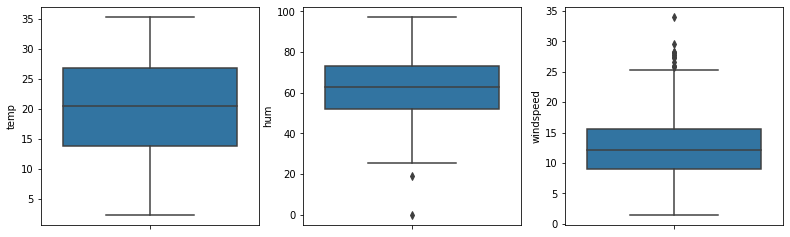

In [16]:
# Draw box plots for indepent variables with continuous values
# cols = ['temp', 'atemp', 'hum', 'windspeed']
cols = ['temp', 'hum', 'windspeed']
plt.figure(figsize=(18,4))

i = 1
for col in cols:
    plt.subplot(1,4,i)
    sns.boxplot(y=col, data=df)
    i+=1

As we can see that for all the contineuos variable, there are no outliers

# 4. EDA

#### 4.1 Converting Seasons , day, and months's numerical values to categorical values

In [17]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,start_of_month,end_of_month,week_of_month,temp_cat
0,1,0,1,0,6,0,2,14.110847,80.5833,10.749882,985,1,0,1,4
1,1,0,1,0,0,0,2,14.902598,69.6087,16.652113,801,0,0,1,4
2,1,0,1,0,1,1,1,8.050924,43.7273,16.636703,1349,0,0,1,4
3,1,0,1,0,2,1,1,8.200000,59.0435,10.739832,1562,0,0,1,4
4,1,0,1,0,3,1,1,9.305237,43.6957,12.522300,1600,0,0,1,4


In [18]:
df['week_of_month'].unique()

array([1, 2, 3, 4, 5, 0])

In [20]:
df.season.replace({1:"spring", 2:"summer", 3:"fall", 4:"winter"},inplace = True)

df.weathersit.replace({1:'good',2:'moderate',3:'bad',4:'severe'},inplace = True)

df.mnth = df.mnth.replace({1: 'jan',2: 'feb',3: 'mar',4: 'apr',5: 'may',6: 'jun',
                  7: 'jul',8: 'aug',9: 'sept',10: 'oct',11: 'nov',12: 'dec'})

df.weekday = df.weekday.replace({0: 'sun',1: 'mon',2: 'tue',3: 'wed',4: 'thu',5: 'fri',6: 'sat'})

[  4,  56, 160, 138, 130, 170,  72]
# df.temp_cat = df.temp_cat.replace({37: 'very_low', 254: 'low', 237: 'medium', 202: 'High'})
df.temp_cat = df.temp_cat.replace({4: 'very_low', 56: 'low', 160: 'medium', 138: 'above_med', 130:'high', 170:'very_high', 72:'extremly_high'})
# df.quarter = df.quarter.replace({1:'first_q', 2:'second_q', 3:'third_q', 4:'fourth_q'})
df.week_of_month = df.week_of_month.replace({1:'week_1', 2:'week_2', 3:'week_3', 4:'week_4', 5:'week_5', 0:'week_0'})
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,start_of_month,end_of_month,week_of_month,temp_cat
0,spring,0,jan,0,sat,0,moderate,14.110847,80.5833,10.749882,985,1,0,week_1,very_low
1,spring,0,jan,0,sun,0,moderate,14.902598,69.6087,16.652113,801,0,0,week_1,very_low
2,spring,0,jan,0,mon,1,good,8.050924,43.7273,16.636703,1349,0,0,week_1,very_low
3,spring,0,jan,0,tue,1,good,8.200000,59.0435,10.739832,1562,0,0,week_1,very_low
4,spring,0,jan,0,wed,1,good,9.305237,43.6957,12.522300,1600,0,0,week_1,very_low


### 4.2 Data Analysis

We now step into Analysis of the data which has been cleaned. For Data Analysis, We can Classify it into Broad Terms:

*   Univariate Analysis
*   Bivariate Analysis
*   Multivariate Analysis

For sake of this Assignment, we will be focusing examples from Univariate Analysis and Bivariate Analysis.

These anaylsis can help give Driving Factors for taking key decisions in order to check for demand on different Parameters using our Linear Regression Models.

###4.2.1 Univariate Analysis

Univariate analysis is perhaps the simplest form of statistical analysis. Like other forms of statistics, it can be inferential or descriptive. The key fact is that only one variable is involved. Univariate analysis can yield misleading results in cases in which multivariate analysis is more appropriate.

Building on this, we go ahead and point out various Univariate Analysis results.

In [21]:
# Overall Average Count of the Bike Demand
print("Mean Count of Bike : {}".format(df['cnt'].mean()))

Mean Count of Bike : 4508.006849315068


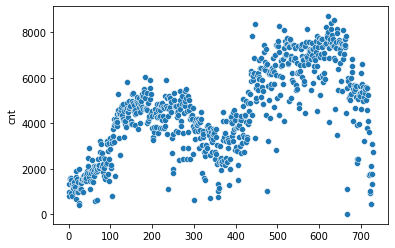

In [22]:
#Scatter Plot of Count
sns.scatterplot(df.index, df['cnt'])

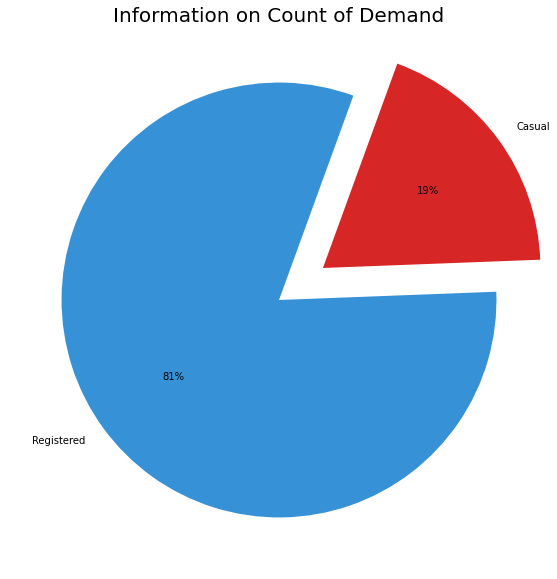

In [23]:
data = [orignal_copy['registered'].sum(), orignal_copy['casual'].sum()]
labels = ['Registered', 'Casual']
plt.figure(figsize = (10,10))
colors = ["#3791D7", "#D72626"]
plt.title('Information on Count of Demand', fontsize=20)
#create pie chart
plt.pie(data,explode=[0,0.25], labels = labels, colors = colors, autopct='%.0f%%', startangle=70)
plt.show()

#### 4.2.2 Bivariate Analysis

Bivariate analysis is one of the simplest forms of quantitative analysis. It involves the analysis of two variables, for the purpose of determining the empirical relationship between them. Bivariate analysis can be helpful in testing simple hypotheses of association.

Building on Univariate Analysis, We can go ahead and start with Relationship between different variables in the dataset.

We performed Correlation for each Non-Categorical Data, i.e. Continuous data column to find any Correlations

<Figure size 1080x2160 with 0 Axes>

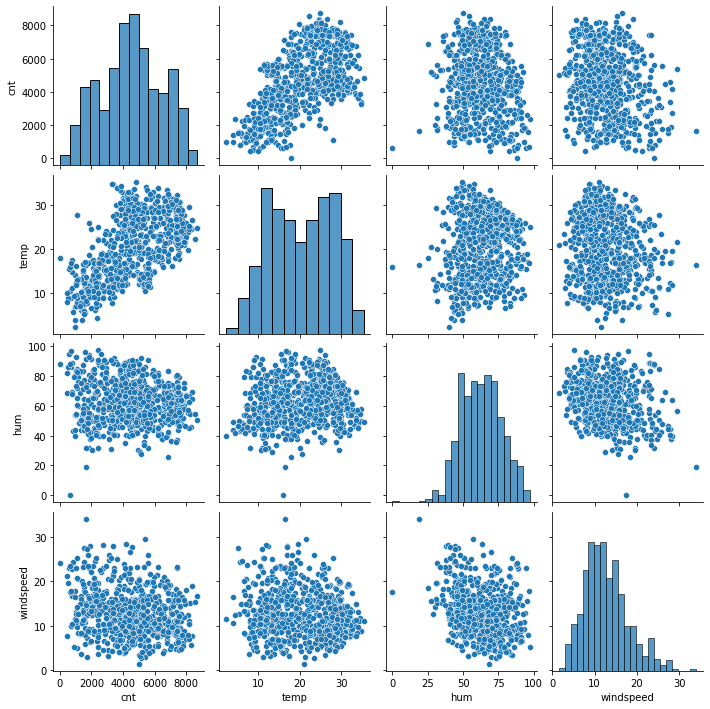

In [24]:
plt.figure(figsize = (15,30))
# sns.pairplot(data=df,vars=['cnt', 'temp', 'atemp', 'hum','windspeed', 'hum_diff', 'temp_diff', 'windspeed_diff', 'hum_pct_change', 'temp_pct_change','windspeed_pct_change'])
# sns.pairplot(data=df,vars=['cnt', 'temp', 'atemp', 'hum','windspeed', 'hum_pct_change', 'temp_pct_change','windspeed_pct_change'])
# sns.pairplot(data=df,vars=['cnt', 'temp', 'atemp', 'hum','windspeed'])
sns.pairplot(data=df,vars=['cnt', 'temp', 'hum','windspeed'])
plt.show()

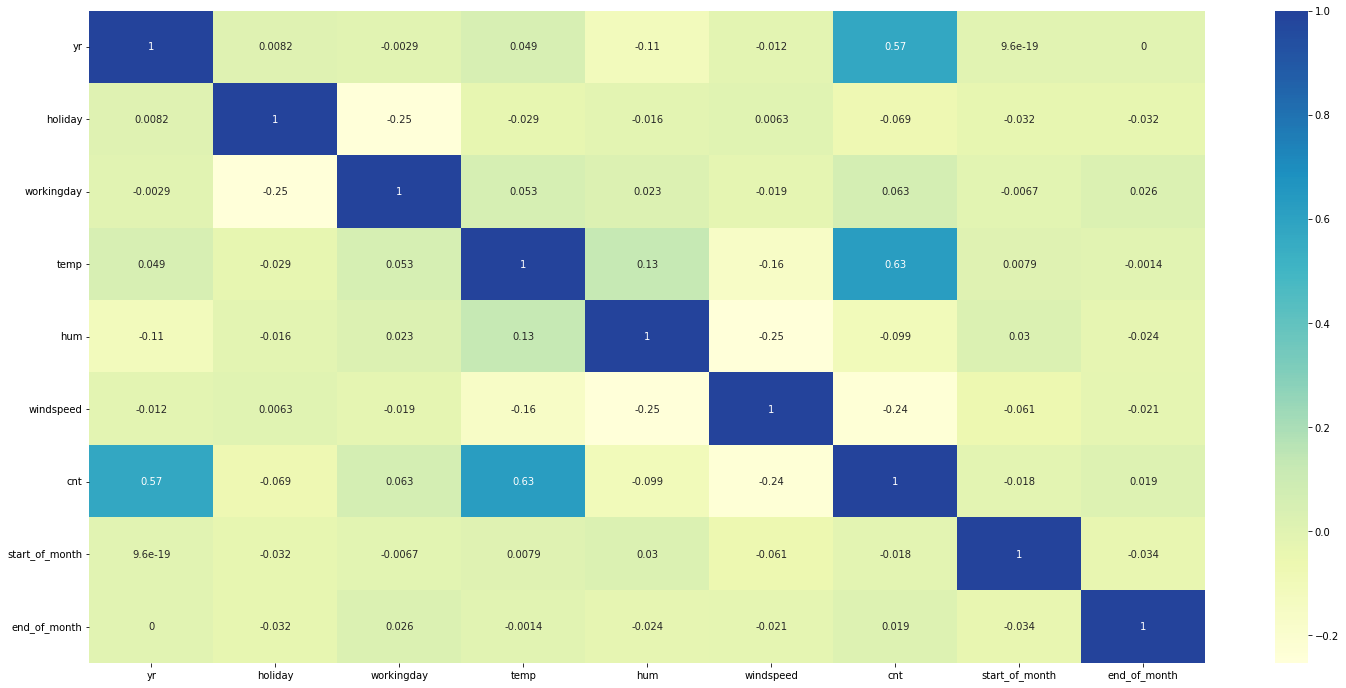

In [25]:
#Correlations for All variables
plt.figure(figsize = (25,12))
sns.heatmap(df.corr(), cmap="YlGnBu", annot = True , center=0.5)
plt.show()

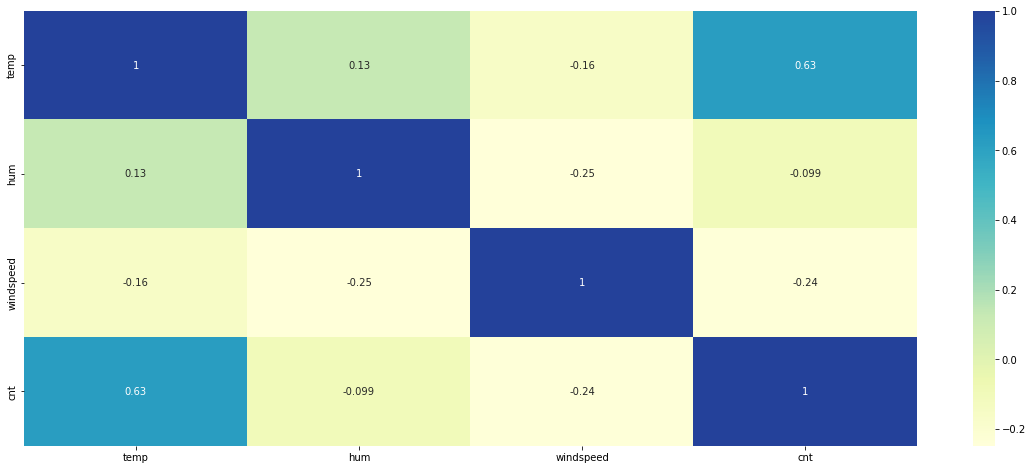

In [26]:
# Heat Map for Contineous Variables
plt.figure(figsize = (20,8))
# sns.heatmap(df[['temp','atemp','hum','windspeed', 'hum_diff', 'temp_diff', 'windspeed_diff', 'hum_pct_change', 'temp_pct_change','windspeed_pct_change' ,'cnt']].corr(), cmap='YlGnBu', annot = True, center=0.5)
# sns.heatmap(df[['temp','atemp','hum','windspeed', 'hum_pct_change', 'temp_pct_change','windspeed_pct_change' ,'cnt']].corr(), cmap='YlGnBu', annot = True, center=0.5)
# sns.heatmap(df[['temp','atemp','hum','windspeed','cnt']].corr(), cmap='YlGnBu', annot = True, center=0.5)
sns.heatmap(df[['temp','hum','windspeed','cnt']].corr(), cmap='YlGnBu', annot = True, center=0.5)
plt.show()

#### From the correlation map, temp and atemp seems to be highly correlated. We can drop one of the columns later in model building
#### Target variable has a linear relationship with respect to indeptendent variables. We can check for Individual Linear relationship with fitting a line to the variables.

#### 4.3 Categorical Variabels distribution

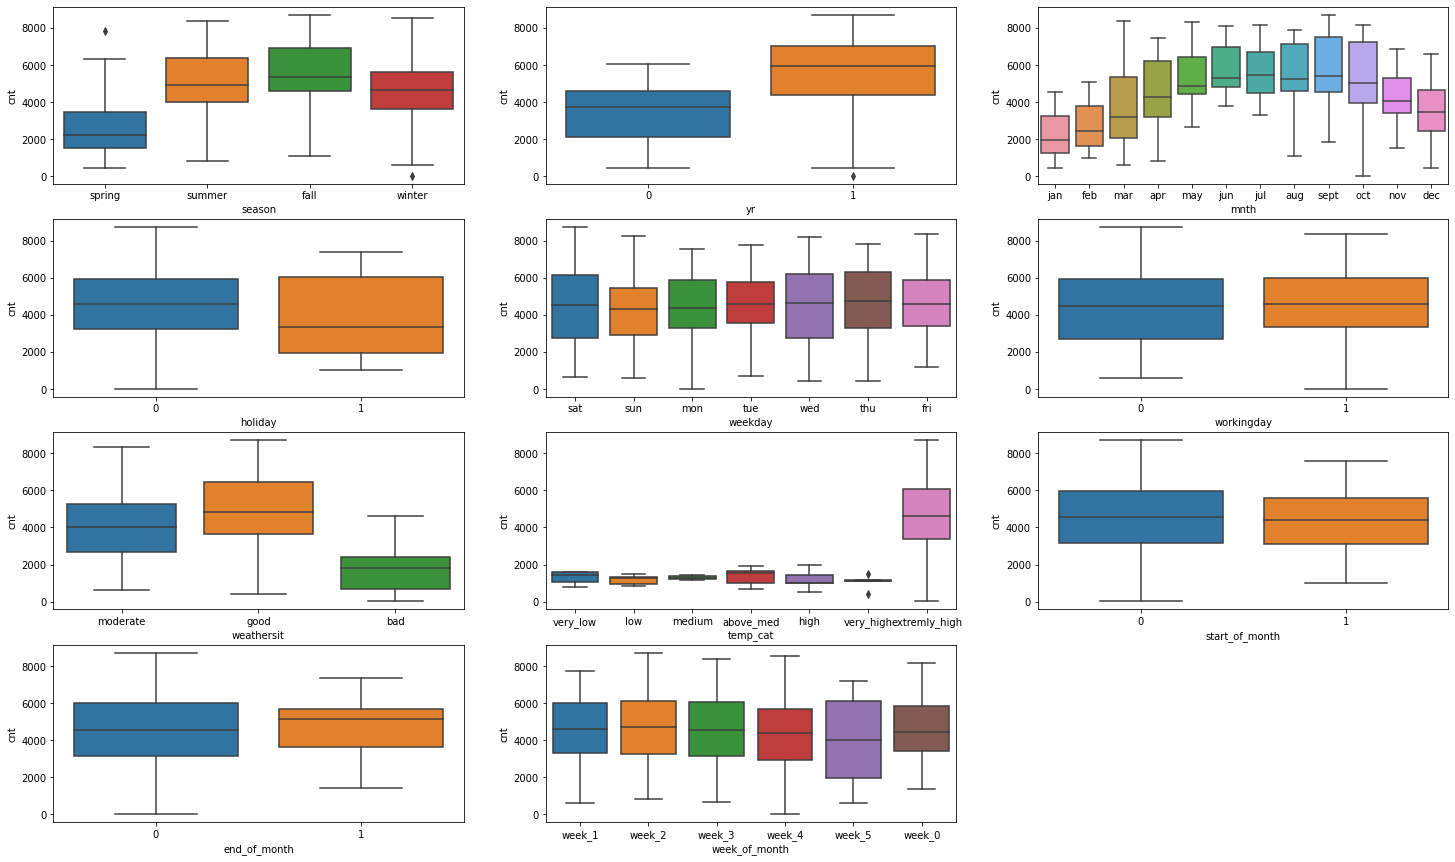

In [27]:
# Boxplot for categorical variables to see demands
# lst = ['season','yr','mnth','holiday','weekday','workingday','weathersit', 
#        'quarter', 'start_of_month',	'end_of_month',	'week_of_month']

lst = ['season','yr','mnth','holiday','weekday','workingday','weathersit', 'temp_cat',
       'start_of_month',	'end_of_month',	'week_of_month']

plt.figure(figsize=(25, 15))
for i in enumerate(lst):
    plt.subplot(4,3,i[0]+1)
    sns.boxplot(data=df, x=i[1], y='cnt')
plt.show()

#### Pointers:
1. Fall has the Higest Demand, whereas spring has the lowest demand
2. Demand in bike sharing business has increased in 2019 compared to 2018
3. Demand keeps on increasing till Septmeber, with september Month being month of Highest demand. And there is decreased demand in from Oct to Jan.
4. Hihger demand when it is not a Holiday.
5. Weekends have slighty higher demand, but the mean is more or less the same. We can derive that there is not much impact of day of week in the data. And similar is with working day
6. Bad weather has lowest demand, where as when the weather is good, there is a high demand.
7. From the demand scale on quaters, there seems to be a steady upward trend in demand for every quater
8. Start of the Month has less deviation in demand compared to rest of the days.
9. End of the Month also has less deviation in demand compared to rest of the days.
10. Week of the Month does not have much to say

####4.4 Fitting the Line in the Graph

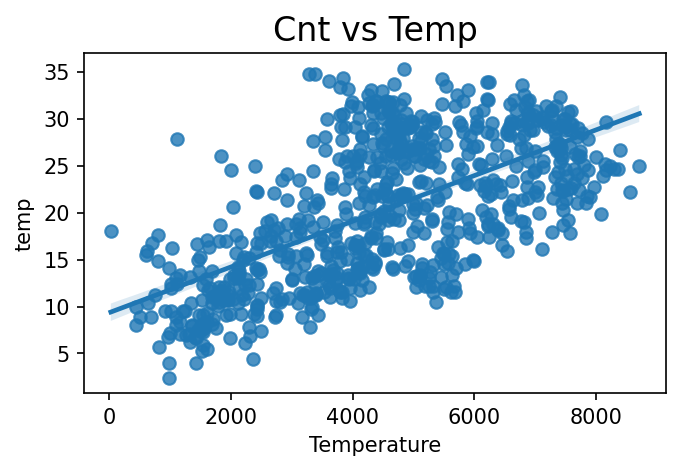

In [28]:
plt.figure(figsize=(5,3),dpi=150)
plt.title("Cnt vs Temp",fontsize=16)
sns.regplot(data=df,x="cnt",y="temp")
plt.xlabel("Temperature")
plt.show()

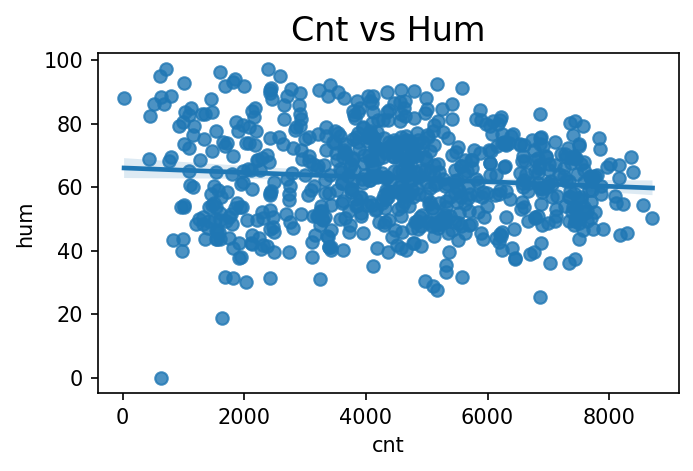

In [29]:
plt.figure(figsize=(5,3),dpi=150)
plt.title("Cnt vs Hum",fontsize=16)
sns.regplot(data=df,x="cnt",y="hum")
plt.show()

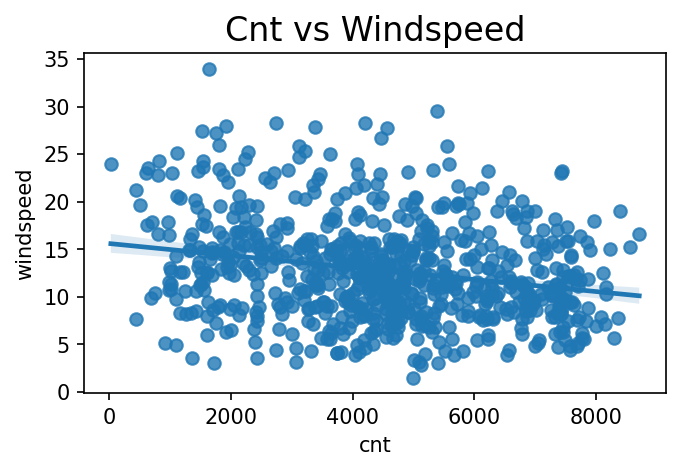

In [30]:
plt.figure(figsize=(5,3),dpi=150)
plt.title("Cnt vs Windspeed",fontsize=16)
sns.regplot(data=df,y="windspeed",x="cnt")
plt.show()

In [31]:
# plt.figure(figsize=(5,3),dpi=150)
# plt.title("Cnt vs hum_pct_change",fontsize=16)
# sns.regplot(data=df,y="hum_pct_change",x='cnt')
# plt.show()
# 'hum_pct_change', 'temp_pct_change','windspeed_pct_change'

In [32]:
# plt.figure(figsize=(5,3),dpi=150)
# plt.title("Cnt vs temp_pct_change",fontsize=16)
# sns.regplot(data=df,y="temp_pct_change",x='cnt')
# plt.show()

In [33]:
# plt.figure(figsize=(5,3),dpi=150)
# plt.title("Cnt vs windspeed_pct_change",fontsize=16)
# sns.regplot(data=df,y='windspeed_pct_change',x='cnt')
# plt.show()

### Pointers
1. Temparture is highly correlated to count
2. Windspeed also has a decent effect of the Count
3. Percent change of the variables seems to have horizontal line plot

# 5. Data Preparation for Model Building

#### 5.1 Creating dummy variables for all the categorical Columns

In [35]:
df = pd.get_dummies(data=df,columns=["season","mnth","weekday", "week_of_month"],drop_first=True)
# df = pd.get_dummies(data=df,columns=["season","mnth","weekday"],drop_first=True)
df = pd.get_dummies(data=df,columns=["weathersit", "temp_cat"])

In [36]:
# Filling NaN row with average of the column and handling infinite values to scale them to 0
df = df.fillna(df.mean())
df.replace(np.inf, 0, inplace=True)

In [37]:
df.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'cnt',
       'start_of_month', 'end_of_month', 'season_spring', 'season_summer',
       'season_winter', 'mnth_aug', 'mnth_dec', 'mnth_feb', 'mnth_jan',
       'mnth_jul', 'mnth_jun', 'mnth_mar', 'mnth_may', 'mnth_nov', 'mnth_oct',
       'mnth_sept', 'weekday_mon', 'weekday_sat', 'weekday_sun', 'weekday_thu',
       'weekday_tue', 'weekday_wed', 'week_of_month_week_1',
       'week_of_month_week_2', 'week_of_month_week_3', 'week_of_month_week_4',
       'week_of_month_week_5', 'weathersit_bad', 'weathersit_good',
       'weathersit_moderate', 'temp_cat_above_med', 'temp_cat_extremly_high',
       'temp_cat_high', 'temp_cat_low', 'temp_cat_medium',
       'temp_cat_very_high', 'temp_cat_very_low'],
      dtype='object')

In [38]:
df.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,start_of_month,end_of_month,season_spring,season_summer,season_winter,mnth_aug,mnth_dec,mnth_feb,mnth_jan,mnth_jul,mnth_jun,mnth_mar,mnth_may,mnth_nov,mnth_oct,mnth_sept,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,week_of_month_week_1,week_of_month_week_2,week_of_month_week_3,week_of_month_week_4,week_of_month_week_5,weathersit_bad,weathersit_good,weathersit_moderate,temp_cat_above_med,temp_cat_extremly_high,temp_cat_high,temp_cat_low,temp_cat_medium,temp_cat_very_high,temp_cat_very_low
0,0,0,0,14.110847,80.5833,10.749882,985,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,0,0,0,14.902598,69.6087,16.652113,801,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0,0,1,8.050924,43.7273,16.636703,1349,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,0,0,1,8.200000,59.0435,10.739832,1562,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,0,0,1,9.305237,43.6957,12.522300,1600,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1


# 6. Model Building

## 5.1 Spliting Data into training and test data

In [39]:
#y to contain only target variable
y = df.pop('cnt')

#X is all remainign variable also our independent variables
X = df

#Train Test split with 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [40]:
# Checking shape and size for train and test
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(511, 43)
(219, 43)
(511,)
(219,)


### 5.2 Scaling continuous variables

In [41]:
# Importing required library
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

In [42]:
#Using MinMax scaler to scale all the variable fron 0 to 1
scaler = MinMaxScaler()
# num_vars = ['temp','atemp','hum','windspeed', 'hum_pct_change', 'temp_pct_change','windspeed_pct_change']
# num_vars = ['temp','atemp','hum','windspeed']
num_vars = ['temp','hum','windspeed']
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])

In [43]:
X_train.describe()

,yr,holiday,workingday,temp,hum,windspeed,start_of_month,end_of_month,season_spring,season_summer,season_winter,mnth_aug,mnth_dec,mnth_feb,mnth_jan,mnth_jul,mnth_jun,mnth_mar,mnth_may,mnth_nov,mnth_oct,mnth_sept,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,week_of_month_week_1,week_of_month_week_2,week_of_month_week_3,week_of_month_week_4,week_of_month_week_5,weathersit_bad,weathersit_good,weathersit_moderate,temp_cat_above_med,temp_cat_extremly_high,temp_cat_high,temp_cat_low,temp_cat_medium,temp_cat_very_high,temp_cat_very_low
count,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000
mean,0.508806,0.025440,0.677104,0.537386,0.650333,0.320844,0.039139,0.029354,0.242661,0.246575,0.248532,0.095890,0.084149,0.066536,0.088063,0.076321,0.076321,0.097847,0.084149,0.086106,0.086106,0.080235,0.150685,0.154599,0.142857,0.133072,0.133072,0.158513,0.223092,0.232877,0.236791,0.183953,0.027397,0.029354,0.626223,0.344423,0.007828,0.954990,0.003914,0.007828,0.007828,0.007828,0.009785
std,0.500412,0.157613,0.468042,0.225640,0.145741,0.169639,0.194115,0.168963,0.429112,0.431440,0.432585,0.294729,0.277883,0.249461,0.283664,0.265771,0.265771,0.297399,0.277883,0.280795,0.280795,0.271923,0.358092,0.361876,0.350270,0.339986,0.339986,0.365579,0.416727,0.423079,0.425529,0.387826,0.163398,0.168963,0.484280,0.475645,0.088214,0.207529,0.062500,0.088214,0.088214,0.088214,0.098529
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.341151,0.538858,0.199179,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.542077,0.653499,0.298098,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.754401,0.414438,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


####As we can see all the variables have been scaled from 0 to 1 now

In [44]:
X_train.head()

,yr,holiday,workingday,temp,hum,windspeed,start_of_month,end_of_month,season_spring,season_summer,season_winter,mnth_aug,mnth_dec,mnth_feb,mnth_jan,mnth_jul,mnth_jun,mnth_mar,mnth_may,mnth_nov,mnth_oct,mnth_sept,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,week_of_month_week_1,week_of_month_week_2,week_of_month_week_3,week_of_month_week_4,week_of_month_week_5,weathersit_bad,weathersit_good,weathersit_moderate,temp_cat_above_med,temp_cat_extremly_high,temp_cat_high,temp_cat_low,temp_cat_medium,temp_cat_very_high,temp_cat_very_low
653,1,0,1,0.509887,0.575354,0.300794,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0
576,1,0,1,0.815169,0.725633,0.264686,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0
426,1,0,0,0.442393,0.640189,0.255342,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
728,1,0,0,0.245101,0.498067,0.663106,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0
482,1,0,0,0.395666,0.504508,0.188475,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0


#### Approach used is combination of Auto Elimination using RFE and Manual Elimination

In [45]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 511 entries, 653 to 520
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   yr                      511 non-null    int64  
 1   holiday                 511 non-null    int64  
 2   workingday              511 non-null    int64  
 3   temp                    511 non-null    float64
 4   hum                     511 non-null    float64
 5   windspeed               511 non-null    float64
 6   start_of_month          511 non-null    int64  
 7   end_of_month            511 non-null    int64  
 8   season_spring           511 non-null    uint8  
 9   season_summer           511 non-null    uint8  
 10  season_winter           511 non-null    uint8  
 11  mnth_aug                511 non-null    uint8  
 12  mnth_dec                511 non-null    uint8  
 13  mnth_feb                511 non-null    uint8  
 14  mnth_jan                511 non-null    

In [46]:
# Lienar Regression model using RFE
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [47]:
# using RFE to rank the columns upto 20
rfe = RFE(lr, n_features_to_select=20, step=1, verbose=0, importance_getter='auto')
rfe.fit(X_train,y_train)

RFE(estimator=LinearRegression(), n_features_to_select=20)

In [48]:
# Columns ranked by thier weights
test_list = list(zip(X_train.columns,rfe.support_,rfe.ranking_))
test_list.sort(key = lambda test_list: test_list[2])
test_list

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('end_of_month', True, 1),
 ('season_spring', True, 1),
 ('season_summer', True, 1),
 ('season_winter', True, 1),
 ('mnth_jan', True, 1),
 ('mnth_jul', True, 1),
 ('mnth_nov', True, 1),
 ('mnth_sept', True, 1),
 ('weekday_sat', True, 1),
 ('weathersit_bad', True, 1),
 ('weathersit_good', True, 1),
 ('weathersit_moderate', True, 1),
 ('temp_cat_above_med', True, 1),
 ('temp_cat_low', True, 1),
 ('mnth_dec', False, 2),
 ('temp_cat_extremly_high', False, 3),
 ('temp_cat_very_low', False, 4),
 ('temp_cat_very_high', False, 5),
 ('temp_cat_high', False, 6),
 ('weekday_sun', False, 7),
 ('temp_cat_medium', False, 8),
 ('mnth_feb', False, 9),
 ('week_of_month_week_4', False, 10),
 ('mnth_may', False, 11),
 ('week_of_month_week_2', False, 12),
 ('mnth_aug', False, 13),
 ('start_of_month', False, 14),
 ('weekday_mon', False, 15),
 ('weekday_tue', False, 16),
 ('wee

## 5.4 Manual Selection

Since we will be using similar approaches to calculate VIF and build multiple models. We create 2 different functions for the same

In [49]:
#Function for Model building using statsmodel api
def build_model(cols):
    X_train_sm = sm.add_constant(X_train[cols])
    lm = sm.OLS(y_train, X_train_sm).fit()
    print(lm.summary())
    return lm

#Calculate VIF
def get_vif(cols):
    df1 = X_train[cols]
    vif = pd.DataFrame()
    vif['Features'] = df1.columns
    vif['VIF'] = [variance_inflation_factor(df1.values, i) for i in range(df1.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    print(vif.sort_values(by='VIF',ascending=False))

In [50]:
#Print Columns selected by RFE. We will start with these columns for manual elimination
X_train.columns[rfe.support_]

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed',
       'end_of_month', 'season_spring', 'season_summer', 'season_winter',
       'mnth_jan', 'mnth_jul', 'mnth_nov', 'mnth_sept', 'weekday_sat',
       'weathersit_bad', 'weathersit_good', 'weathersit_moderate',
       'temp_cat_above_med', 'temp_cat_low'],
      dtype='object')

In [51]:
# Features not selected by RFE
X_train.columns[~rfe.support_]

Index(['start_of_month', 'mnth_aug', 'mnth_dec', 'mnth_feb', 'mnth_jun',
       'mnth_mar', 'mnth_may', 'mnth_oct', 'weekday_mon', 'weekday_sun',
       'weekday_thu', 'weekday_tue', 'weekday_wed', 'week_of_month_week_1',
       'week_of_month_week_2', 'week_of_month_week_3', 'week_of_month_week_4',
       'week_of_month_week_5', 'temp_cat_extremly_high', 'temp_cat_high',
       'temp_cat_medium', 'temp_cat_very_high', 'temp_cat_very_low'],
      dtype='object')

In [58]:
# Taking 20 columns supported by RFE for regression
X_train_rfe = X_train[list(X_train.columns[rfe.support_])]
X_train_rfe.shape

(511, 20)

# 6. Model Building and Score Checks 
### 6.1 Model 1:
All the columns supported by the RFE

In [59]:
cols = list(X_train.columns[rfe.support_])
build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     148.7
Date:                Tue, 11 Jan 2022   Prob (F-statistic):          1.22e-189
Time:                        09:07:28   Log-Likelihood:                -4108.6
No. Observations:                 511   AIC:                             8257.
Df Residuals:                     491   BIC:                             8342.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 965.8094    

In [60]:
# plt.figure(figsize = (15,10))
# sns.heatmap(df[cols].corr(), cmap='GnBu', annot=True)
# plt.show()

In [61]:
cols.remove('mnth_nov')
build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     156.4
Date:                Tue, 11 Jan 2022   Prob (F-statistic):          2.74e-190
Time:                        09:07:50   Log-Likelihood:                -4109.7
No. Observations:                 511   AIC:                             8257.
Df Residuals:                     492   BIC:                             8338.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 922.3511    

In [62]:
cols.remove('temp_cat_low')
build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     164.8
Date:                Tue, 11 Jan 2022   Prob (F-statistic):          9.42e-191
Time:                        09:08:13   Log-Likelihood:                -4111.3
No. Observations:                 511   AIC:                             8259.
Df Residuals:                     493   BIC:                             8335.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 961.5378    

In [63]:
cols.remove('temp_cat_above_med')
build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     174.1
Date:                Tue, 11 Jan 2022   Prob (F-statistic):          3.57e-191
Time:                        09:08:41   Log-Likelihood:                -4113.0
No. Observations:                 511   AIC:                             8260.
Df Residuals:                     494   BIC:                             8332.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 957.0420    

In [64]:
##
cols.remove('end_of_month')
build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     184.5
Date:                Tue, 11 Jan 2022   Prob (F-statistic):          1.50e-191
Time:                        09:09:06   Log-Likelihood:                -4114.8
No. Observations:                 511   AIC:                             8262.
Df Residuals:                     495   BIC:                             8329.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 993.3886    

In [65]:
cols.remove('mnth_jan')
build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     196.2
Date:                Tue, 11 Jan 2022   Prob (F-statistic):          7.31e-192
Time:                        09:09:27   Log-Likelihood:                -4116.8
No. Observations:                 511   AIC:                             8264.
Df Residuals:                     496   BIC:                             8327.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 922.5989    

In [66]:
cols.remove('weathersit_good')
build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     196.2
Date:                Tue, 11 Jan 2022   Prob (F-statistic):          7.31e-192
Time:                        09:09:52   Log-Likelihood:                -4116.8
No. Observations:                 511   AIC:                             8264.
Df Residuals:                     496   BIC:                             8327.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                2105.3594    

In [67]:
cols.remove('hum')
build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     202.7
Date:                Tue, 11 Jan 2022   Prob (F-statistic):          4.84e-189
Time:                        09:10:09   Log-Likelihood:                -4126.3
No. Observations:                 511   AIC:                             8281.
Df Residuals:                     497   BIC:                             8340.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1382.9821    

In [68]:
cols.remove('temp')
build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     138.3
Date:                Tue, 11 Jan 2022   Prob (F-statistic):          6.79e-150
Time:                        09:10:34   Log-Likelihood:                -4222.0
No. Observations:                 511   AIC:                             8470.
Df Residuals:                     498   BIC:                             8525.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                4726.4261    

In [69]:
cols.remove('mnth_jul')
build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     151.1
Date:                Tue, 11 Jan 2022   Prob (F-statistic):          6.01e-151
Time:                        09:11:39   Log-Likelihood:                -4222.2
No. Observations:                 511   AIC:                             8468.
Df Residuals:                     499   BIC:                             8519.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                4691.6277    

In [70]:
cols.remove('holiday')
build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     165.1
Date:                Tue, 11 Jan 2022   Prob (F-statistic):          2.23e-151
Time:                        09:11:58   Log-Likelihood:                -4223.8
No. Observations:                 511   AIC:                             8470.
Df Residuals:                     500   BIC:                             8516.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                4623.1969    

In [71]:
#Build a model with all columns to select features automatically
def build_model_sk(X,y):
    lr1 = LinearRegression()
    lr1.fit(X,y)
    return lr1

In [72]:
#Let us build the finalmodel using sklearn
#Build a model with above columns
lr = build_model_sk(X_train[cols],y_train)
print(lr.intercept_,lr.coef_)

4623.196882951351 [ 2156.28036415   494.53258263 -1494.81832423 -2580.65876722
  -350.66338566  -635.20644802   626.49389001   555.67316651
 -2615.85760504  -792.90652148]


## Step 7. Model Evaluation 
### 7.1 Residucal Analysis

In [73]:
y_train_pred = lr.predict(X_train[cols])

In [74]:
#Plot a histogram of the error terms
def plot_res_dist(act, pred):
    sns.distplot(act-pred)
    plt.title('Error Terms')
    plt.xlabel('Errors')

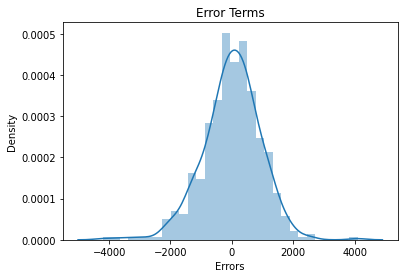

In [75]:
plot_res_dist(y_train, y_train_pred)

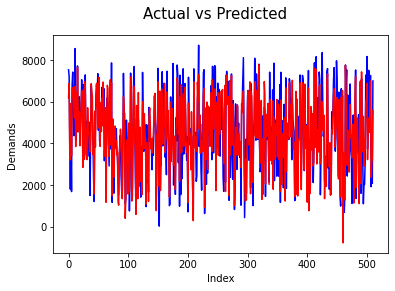

In [76]:
# Actual vs Predicted
c = [i for i in range(0,len(X_train),1)]
plt.plot(c,y_train, color="blue")
plt.plot(c,y_train_pred, color="red")
plt.suptitle('Actual vs Predicted', fontsize = 15)
plt.xlabel('Index')
plt.ylabel('Demands')
plt.show()

In [77]:
#Print R-squared Value
r2_score(y_train,y_train_pred)

0.7675618618262408

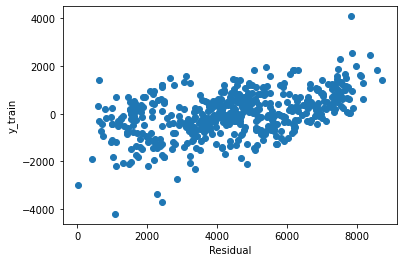

In [78]:
# scatter plot for the check
residual = (y_train - y_train_pred)
plt.scatter(y_train,residual)
plt.ylabel("y_train")
plt.xlabel("Residual")
plt.show()

In [79]:
#Test data to be transformed only, no fitting
num_vars = ['temp','hum','windspeed']
X_test[num_vars] = scaler.transform(X_test[num_vars])

In [80]:
#Predict the values for test data
y_test_pred = lr.predict(X_test[cols])

In [81]:
# Find out the R squared value between test and predicted test data sets.  
r2_score(y_test,y_test_pred)

0.750890710102137

In [82]:
# Error terms
def plot_err_terms(act,pred):
    c = [i for i in range(1,220,1)]
    fig = plt.figure(figsize=(14,5))
    plt.plot(c,act-pred, color="blue", marker='o', linewidth=2.5, linestyle="")
    fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
    plt.xlabel('Index', fontsize=18)                      # X-label
    plt.ylabel('Counts - Predicted Counts', fontsize=16)                # Y-label

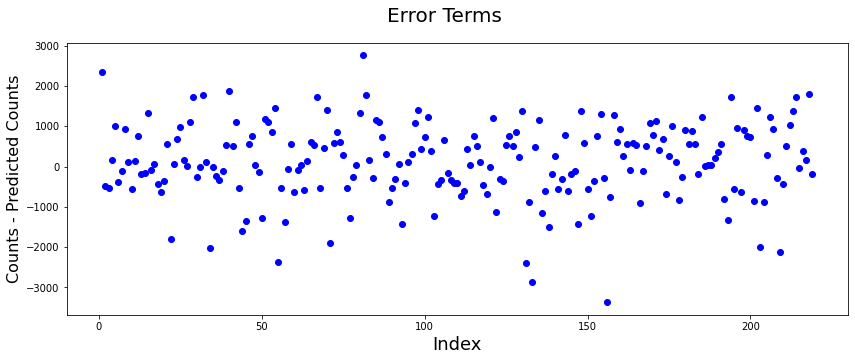

In [83]:
#Plot error terms for test data
plot_err_terms(y_test,y_test_pred)

In [84]:
# Checking data before scaling
df.head()

,yr,holiday,workingday,temp,hum,windspeed,start_of_month,end_of_month,season_spring,season_summer,season_winter,mnth_aug,mnth_dec,mnth_feb,mnth_jan,mnth_jul,mnth_jun,mnth_mar,mnth_may,mnth_nov,mnth_oct,mnth_sept,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,week_of_month_week_1,week_of_month_week_2,week_of_month_week_3,week_of_month_week_4,week_of_month_week_5,weathersit_bad,weathersit_good,weathersit_moderate,temp_cat_above_med,temp_cat_extremly_high,temp_cat_high,temp_cat_low,temp_cat_medium,temp_cat_very_high,temp_cat_very_low
0,0,0,0,14.110847,80.5833,10.749882,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,0,0,0,14.902598,69.6087,16.652113,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0,0,1,8.050924,43.7273,16.636703,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,0,0,1,8.200000,59.0435,10.739832,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,0,0,1,9.305237,43.6957,12.522300,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [85]:
lm = build_model(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     165.1
Date:                Tue, 11 Jan 2022   Prob (F-statistic):          2.23e-151
Time:                        09:21:07   Log-Likelihood:                -4223.8
No. Observations:                 511   AIC:                             8470.
Df Residuals:                     500   BIC:                             8516.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                4623.1969    